In [7]:
!pip install -q torch==1.0.1

     |████████████████████████████████| 560.1MB 26kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.0.1 which is incompatible.


In [8]:
import torch
print(torch.__version__)

1.0.1


In [9]:
!pip install ekphrasis

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 194kB 14.2MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-cp36-none-any.whl size=82844 sha256=3f996eed5580e3bd656554578982d1f4a386264a1dd9af558686b57f2c61e656
  Stored in directory: /root/.cache/pip/wheels/2f/c5/9b/c9b60f535a2cf9fdbc92d84c4801a010c35a9cd348011ed2a1
  Created wheel for ujson: filename=ujson-1.35-cp36-cp36m-linux_x86_64.whl size=68021 sha256=293b62415919a00f2261e6a01a9b02aafff32fd6677bb28f8170896d84704c6d
  Stored in directory: /root/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44553 sha256=a53794d68b339494fb08de2716bd232ee90309c5d060c7c5c662e4dab163b737
  Stored in directory: /root/.cache/pip/wheels/43/34/ce/cbb38d71543c408de56f3c5e26ce8ba495a0fa5a28eaaf1046
Successfully built ekphrasis ujson ftfy


In [10]:
!pip install emoji

     |████████████████████████████████| 51kB 2.1MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=6abd2a8d10cbf7afd849e59dccab36fb508e467d6c7694a072e8c4db94b121d3
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer

In [0]:
%cd contextual_emotion_detection

In [0]:
%cd torchMoji
from torchmoji.model_def import torchmoji_emojis
from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH
%cd ..

In [0]:
%cd deepmoji

In [0]:
dirpath = '.'
projectpath = os.path.join(dirpath, '..')
datapath = os.path.join(projectpath, 'data')
torhchmojipath = os.path.join(projectpath, 'deepmoji')

emotion_to_label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}
label_to_emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}

additional_emoticons = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

In [0]:
training_data = pd.read_csv(os.path.join(datapath, 'train.txt'), sep = '\t')

In [17]:
text_pre_processor = TextPreProcessor(
    normalize = ['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    annotate = {"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html = True,
    segmenter = "twitter",
    corrector = "twitter", # spell correction
    unpack_hashtags = True,
    unpack_contractions = True, # expand word abbreviations
    spell_correct_elong = True,
    tokenizer = SocialTokenizer(lowercase = True).tokenize,
    dicts = [emoticons, additional_emoticons]
)

def pre_process(conversation_text):
    conversation_text = " ".join(text_pre_processor.pre_process_doc(conversation_text))
    return conversation_text

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


### Load data

In [0]:
conversation = []
label = []

for index, record in training_data.iterrows():
    conversation.append(pre_process(record['turn1']) +' <eos> ' + pre_process(record['turn2']) + ' <eos> ' + pre_process(record['turn3']))
    label.append(emotion_to_label[record['label']])

In [0]:
test_data = pd.read_csv(os.path.join(datapath, 'test.txt'), sep = '\t')

In [0]:
test_conversation = []
test_label = []

for index, record in test_data.iterrows():
    test_conversation.append(pre_process(record['turn1'])+' <eos> ' + pre_process(record['turn2']) + ' <eos> ' + pre_process(record['turn3']))
    test_label.append(emotion_to_label[record['label']])

### Encoding conversations to fixed sized vector encodings

In [0]:
def encode_deepmoji(conversation_text):
    model = torchmoji_feature_encoding(PRETRAINED_PATH)
    vector_size = 30
    batch_size = 32
    print("Tokenizing conversation text")
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    tokenizer = SentenceTokenizer(vocabulary, vector_size)
    tokenized_conversation, _, _ = tokenizer.tokenize_sentences(conversation_text)
    print("Make predictions using Pretrained model: ", model)    
    conversation_encoding = np.zeros((len(conversation_text), 2304))
    for index in range(0, len(conversation_text), 300):    
        conversation_encoding[index : index + 300] = model(tokenized_conversation[index : index + 300])
    return conversation_encoding

# Use the pre-trained model provided by torcMoji
# which is a PyTorch implementation of DeepMoji
def encode_emoji(conversation_text):
    model = torchmoji_emojis(PRETRAINED_PATH)
    vector_size = 30
    batch_size = 32
    print("Tokenizing conversation text")
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    tokenizer = SentenceTokenizer(vocabulary, vector_size)
    tokenized_conversation, _, _ = tokenizer.tokenize_sentences(conversation_text)
    print("Make predictions using Pretrained model: ", model)    
    conversation_encoding = np.zeros((len(conversation_text), 64))
    for index in range(0, len(conversation_text), 300):    
        conversation_encoding[index : index + 300] = model(tokenized_conversation[index : index + 300])
    return conversation_encoding

### Create vectors

In [22]:
conversation_encoding_vector = encode_deepmoji(conversation)

/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:159: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.embed.weight.data, a=-0.5, b=0.5)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:161: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:163: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:165: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(t, 0)


Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights for output_layer.0.weight
Ignoring weights for output_layer.0.bias
Tokenizing conversation text
Make predictions using Pretrained model:  TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [23]:
test_conversation_encoding_vector = encode_deepmoji(test_conversation)

/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:159: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.embed.weight.data, a=-0.5, b=0.5)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:161: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:163: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:165: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(t, 0)


Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights for output_layer.0.weight
Ignoring weights for output_layer.0.bias
Tokenizing conversation text
Make predictions using Pretrained model:  TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [0]:
%mkdir deepemoji_embeddings

In [0]:
np.save(os.path.join(dirpath, 'deepemoji_embeddings', 'conversation_encoding_vector'), conversation_encoding_vector)

In [0]:
np.save(os.path.join(dirpath, 'deepemoji_embeddings', 'test_conversation_encoding_vector'), test_conversation_encoding_vector)

### Load saved vectors

In [0]:
conversation_encoding_vector = np.load(os.path.join(dirpath, 'deepemoji_embeddings', 'conversation_encoding_vector.npy'))
test_conversation_encoding_vector = np.load(os.path.join(dirpath, 'deepemoji_embeddings', 'test_conversation_encoding_vector.npy'))

In [28]:
print(conversation_encoding_vector.shape)
print(test_conversation_encoding_vector.shape)

(30160, 2304)
(5509, 2304)


In [29]:
emoji_all = encode_emoji(conversation)
emoji_test = encode_emoji(test_conversation)

/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:159: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.embed.weight.data, a=-0.5, b=0.5)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:161: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:163: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(t)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:165: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(t, 0)
/content/contextual_emotion_detection/torchMoji/torchmoji/model_def.py:167: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.output_layer[0].weight.data)


Tokenizing conversation text
Make predictions using Pretrained model:  TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Tokenizing conversation text
Make predictions using Pretrained model:  TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)


In [30]:
tokens = [v for k,v in label_to_emotion.items()]
tokens

['others', 'happy', 'sad', 'angry']

In [0]:
label = np.array(label)
indices_of_other_records = np.where(label == 0)[0]

In [0]:
selected_record_indices = np.r_[np.random.choice(indices_of_other_records, 6000), np.where(label == 1)[0], np.where(label == 2)[0], np.where(label == 3)[0]]

In [33]:
selected_record_indices.shape

(21212,)

In [0]:
deepmoji_train = conversation_encoding_vector[selected_record_indices]
labels_train = label[selected_record_indices]
emoji_train = emoji_all[selected_record_indices]

In [0]:
deepmoji_test = test_conversation_encoding_vector

### Models

In [0]:
from sklearn import metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import itertools
from sklearn.linear_model import LogisticRegression
import seaborn as sn
import matplotlib.cm as cm

In [0]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize = False, 
                          cmap = cm.YlGn, 
                          png_output = None, 
                          show = True):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title='Normalized confusion matrix'
        else:
            title='Confusion matrix'

        # Calculate chart area size
        leftmargin = 0.5 # inches
        rightmargin = 0.5 # inches
        categorysize = 0.5 # inches
        figwidth = leftmargin + rightmargin + (len(classes) * categorysize) + 2          

        f = plt.figure(figsize = (figwidth, figwidth))

        # Create an axes instance and ajust the subplot size
        ax = f.add_subplot(111)
        ax.set_aspect(1)
        f.subplots_adjust(left = leftmargin/figwidth, right = 1 - rightmargin/figwidth, top = 0.94, bottom = 0.1)

        res = ax.imshow(cm, interpolation = 'nearest', cmap = cmap)

        plt.title(title)
        plt.colorbar(res)
        ax.set_xticks(range(len(classes)))
        ax.set_yticks(range(len(classes)))
        ax.set_xticklabels(classes, rotation = 45, ha='right')
        ax.set_yticklabels(classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
                    horizontalalignment = "center",
                    color = "white" if cm[i, j] > thresh else "black")

        # plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        if png_output is not None:
            os.makedirs(png_output, exist_ok = True)
            f.savefig(os.path.join(png_output,'confusion_matrix.png'), bbox_inches = 'tight')

        if show:
            plt.show()
            plt.close(f)
        else:
            plt.close(f)

In [0]:
def print_metrics(prediction):
    print(metrics.classification_report(test_label, prediction, target_names = tokens))
    print("Accuracy:", metrics.accuracy_score(test_label, prediction))
    print("Precision:", metrics.precision_score(test_label, prediction, average = 'macro'))
    print("Recall:", metrics.recall_score(test_label, prediction, average = 'macro'))
    print("F1 score: ", metrics.f1_score(test_label, prediction, average = 'macro'))

### Logistic Regression

In [39]:
logistic_regression = Pipeline([('scaler', MinMaxScaler()), ('clf', LogisticRegression(random_state = 0))])
logistic_regression.fit(deepmoji_train, labels_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=0, solver='warn',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [40]:
logistic_regression_predictions = logistic_regression.predict(deepmoji_test)
print_metrics(logistic_regression_predictions)

              precision    recall  f1-score   support

      others       0.97      0.78      0.86      4677
       happy       0.31      0.70      0.43       284
         sad       0.37      0.71      0.49       250
       angry       0.39      0.84      0.54       298

    accuracy                           0.77      5509
   macro avg       0.51      0.76      0.58      5509
weighted avg       0.88      0.77      0.80      5509

Accuracy: 0.7727355236885097
Precision: 0.5110081626603824
Recall: 0.7585545392786119
F1 score:  0.579214561757912


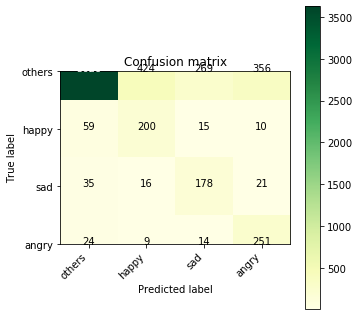

array([[3628,  424,  269,  356],
       [  59,  200,   15,   10],
       [  35,   16,  178,   21],
       [  24,    9,   14,  251]])

In [73]:
plot_confusion_matrix(metrics.confusion_matrix(test_label, logistic_regression_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, logistic_regression_predictions)

In [76]:
logistic_regression = LogisticRegression(random_state = 0)
logistic_regression.fit(deepmoji_train, labels_train) 
logistic_regression_predictions = logistic_regression.predict(deepmoji_test)
print_metrics(logistic_regression_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      others       0.97      0.78      0.86      4677
       happy       0.32      0.68      0.44       284
         sad       0.38      0.71      0.49       250
       angry       0.37      0.83      0.51       298

    accuracy                           0.77      5509
   macro avg       0.51      0.75      0.58      5509
weighted avg       0.87      0.77      0.81      5509

Accuracy: 0.7738246505717916
Precision: 0.5091537412509763
Recall: 0.7490403734929938
F1 score:  0.576280061534569


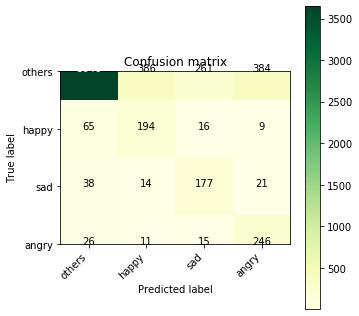

array([[3646,  386,  261,  384],
       [  65,  194,   16,    9],
       [  38,   14,  177,   21],
       [  26,   11,   15,  246]])

In [77]:
plot_confusion_matrix(metrics.confusion_matrix(test_label, logistic_regression_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, logistic_regression_predictions)

In [80]:
logistic_regression = LogisticRegression(random_state = 0).fit(conversation_encoding_vector, label)
logistic_regression_predictions = logistic_regression.predict(deepmoji_test)
print_metrics(logistic_regression_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      others       0.95      0.89      0.92      4677
       happy       0.45      0.52      0.48       284
         sad       0.51      0.64      0.57       250
       angry       0.51      0.78      0.62       298

    accuracy                           0.86      5509
   macro avg       0.61      0.71      0.65      5509
weighted avg       0.88      0.86      0.87      5509

Accuracy: 0.8571428571428571
Precision: 0.6050265191526082
Recall: 0.7092387669683302
F1 score:  0.6473441923387087


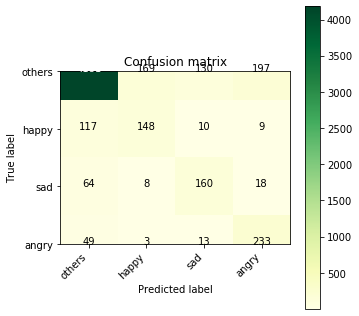

array([[4181,  169,  130,  197],
       [ 117,  148,   10,    9],
       [  64,    8,  160,   18],
       [  49,    3,   13,  233]])

In [81]:
plot_confusion_matrix(metrics.confusion_matrix(test_label, logistic_regression_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, logistic_regression_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      others       0.91      0.71      0.80      4677
       happy       0.17      0.36      0.23       284
         sad       0.26      0.52      0.35       250
       angry       0.26      0.66      0.38       298

    accuracy                           0.68      5509
   macro avg       0.40      0.56      0.44      5509
weighted avg       0.81      0.68      0.72      5509

Accuracy: 0.6792521328734797
Precision: 0.39975695499397956
Recall: 0.5647060523970834
F1 score:  0.43669716339221204


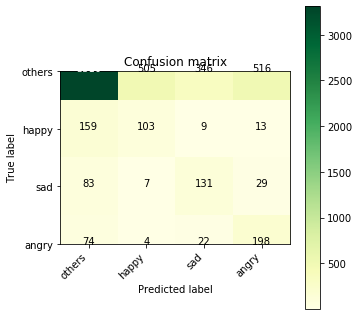

array([[3310,  505,  346,  516],
       [ 159,  103,    9,   13],
       [  83,    7,  131,   29],
       [  74,    4,   22,  198]])

In [82]:
logistic_regression = LogisticRegression(random_state = 0).fit(emoji_train, labels_train)
logistic_regression_predictions = logistic_regression.predict(emoji_test)
print_metrics(logistic_regression_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, logistic_regression_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, logistic_regression_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

      others       0.89      0.94      0.91      4677
       happy       0.30      0.04      0.06       284
         sad       0.42      0.38      0.40       250
       angry       0.46      0.47      0.46       298

    accuracy                           0.84      5509
   macro avg       0.52      0.45      0.46      5509
weighted avg       0.81      0.84      0.82      5509

Accuracy: 0.840624432746415
Precision: 0.515931836645843
Recall: 0.4539656184448747
F1 score:  0.45797271479770607


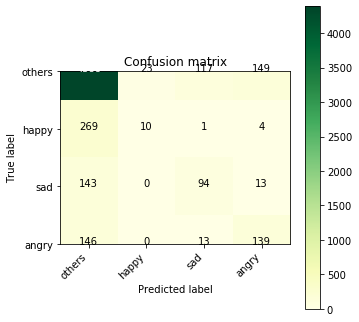

array([[4388,   23,  117,  149],
       [ 269,   10,    1,    4],
       [ 143,    0,   94,   13],
       [ 146,    0,   13,  139]])

In [83]:
logistic_regression = LogisticRegression(random_state = 0).fit(emoji_all, label)
logistic_regression_predictions = logistic_regression.predict(emoji_test)
print_metrics(logistic_regression_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, logistic_regression_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, logistic_regression_predictions)

### Naive Bayes

              precision    recall  f1-score   support

      others       0.93      0.75      0.83      4677
       happy       0.27      0.54      0.36       284
         sad       0.37      0.54      0.44       250
       angry       0.26      0.73      0.39       298

    accuracy                           0.73      5509
   macro avg       0.46      0.64      0.51      5509
weighted avg       0.84      0.73      0.77      5509

Accuracy: 0.72898892721002
Precision: 0.46062553396209366
Recall: 0.6384158984815529
F1 score:  0.5054345017418674


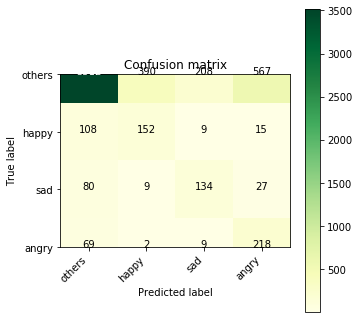

array([[3512,  390,  208,  567],
       [ 108,  152,    9,   15],
       [  80,    9,  134,   27],
       [  69,    2,    9,  218]])

In [85]:
naive_bayes = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
naive_bayes.fit(deepmoji_train, labels_train)
naive_bayes_predictions = naive_bayes.predict(deepmoji_test)
print_metrics(naive_bayes_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, naive_bayes_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, naive_bayes_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      others       0.88      0.90      0.89      4677
       happy       0.00      0.00      0.00       284
         sad       0.42      0.34      0.38       250
       angry       0.27      0.45      0.34       298

    accuracy                           0.81      5509
   macro avg       0.39      0.43      0.40      5509
weighted avg       0.78      0.81      0.79      5509

Accuracy: 0.8079506262479579
Precision: 0.39262305369971356
Recall: 0.42536151206891354
F1 score:  0.40202658844873435


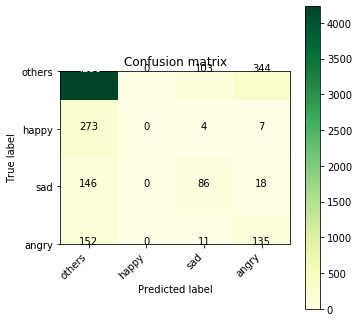

array([[4230,    0,  103,  344],
       [ 273,    0,    4,    7],
       [ 146,    0,   86,   18],
       [ 152,    0,   11,  135]])

In [86]:
naive_bayes = Pipeline([('clf', MultinomialNB())])
naive_bayes.fit(emoji_train, labels_train)
naive_bayes_predictions = naive_bayes.predict(emoji_test)
print_metrics(naive_bayes_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, naive_bayes_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, naive_bayes_predictions)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

      others       0.85      1.00      0.92      4677
       happy       0.00      0.00      0.00       284
         sad       0.00      0.00      0.00       250
       angry       0.00      0.00      0.00       298

    accuracy                           0.85      5509
   macro avg       0.21      0.25      0.23      5509
weighted avg       0.72      0.85      0.78      5509

Accuracy: 0.8489744055182429
Precision: 0.21224360137956072
Recall: 0.25
F1 score:  0.22957981543294717


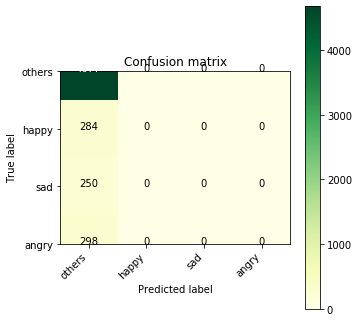

array([[4677,    0,    0,    0],
       [ 284,    0,    0,    0],
       [ 250,    0,    0,    0],
       [ 298,    0,    0,    0]])

In [87]:
naive_bayes = Pipeline([('clf', MultinomialNB())])
naive_bayes.fit(emoji_all, label)
naive_bayes_predictions = naive_bayes.predict(emoji_test)
print_metrics(naive_bayes_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, naive_bayes_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, naive_bayes_predictions)

### SVM - One vs One


              precision    recall  f1-score   support

      others       0.93      0.71      0.80      4677
       happy       0.18      0.49      0.26       284
         sad       0.31      0.61      0.41       250
       angry       0.31      0.72      0.44       298

    accuracy                           0.69      5509
   macro avg       0.43      0.63      0.48      5509
weighted avg       0.83      0.69      0.74      5509

Accuracy: 0.691051007442367
Precision: 0.4331946835850715
Recall: 0.6321647630421798
F1 score:  0.47852264021584967


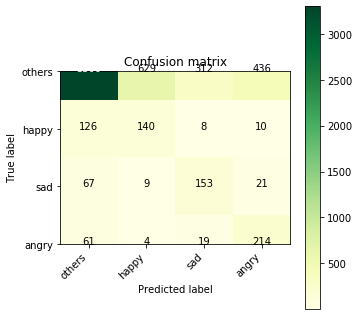

array([[3300,  629,  312,  436],
       [ 126,  140,    8,   10],
       [  67,    9,  153,   21],
       [  61,    4,   19,  214]])

In [88]:
support_vector_machine_one_vs_one = svm.SVC(decision_function_shape = 'ovo', kernel = 'linear', C = 100)
support_vector_machine_one_vs_one.fit(emoji_train, labels_train)
support_vector_machine_one_vs_one_predictions = support_vector_machine_one_vs_one.predict(emoji_test)
print_metrics(support_vector_machine_one_vs_one_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, support_vector_machine_one_vs_one_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, support_vector_machine_one_vs_one_predictions)

              precision    recall  f1-score   support

      others       0.91      0.90      0.91      4677
       happy       0.40      0.24      0.30       284
         sad       0.44      0.49      0.46       250
       angry       0.43      0.59      0.50       298

    accuracy                           0.83      5509
   macro avg       0.54      0.56      0.54      5509
weighted avg       0.83      0.83      0.83      5509

Accuracy: 0.832819023416228
Precision: 0.5429048658814242
Recall: 0.5560158442291393
F1 score:  0.54130883565249


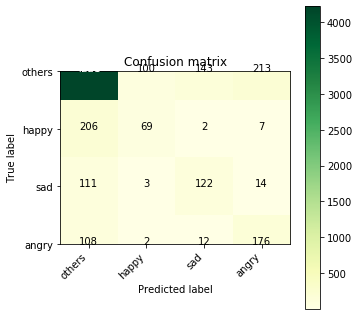

array([[4221,  100,  143,  213],
       [ 206,   69,    2,    7],
       [ 111,    3,  122,   14],
       [ 108,    2,   12,  176]])

In [89]:
support_vector_machine_one_vs_one = svm.SVC(decision_function_shape = 'ovo', kernel = 'linear', C = 100)
support_vector_machine_one_vs_one.fit(emoji_all, label)
support_vector_machine_one_vs_one_predictions = support_vector_machine_one_vs_one.predict(emoji_test)
print_metrics(support_vector_machine_one_vs_one_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, support_vector_machine_one_vs_one_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, support_vector_machine_one_vs_one_predictions)

### SVM One vs Rest

              precision    recall  f1-score   support

      others       0.93      0.71      0.80      4677
       happy       0.18      0.49      0.26       284
         sad       0.31      0.61      0.41       250
       angry       0.31      0.72      0.44       298

    accuracy                           0.69      5509
   macro avg       0.43      0.63      0.48      5509
weighted avg       0.83      0.69      0.74      5509

Accuracy: 0.691051007442367
Precision: 0.4331946835850715
Recall: 0.6321647630421798
F1 score:  0.47852264021584967


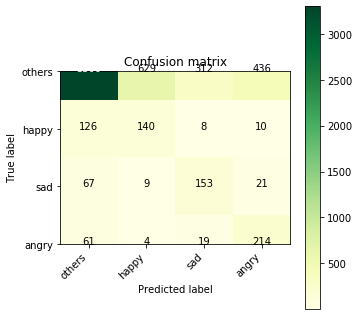

array([[3300,  629,  312,  436],
       [ 126,  140,    8,   10],
       [  67,    9,  153,   21],
       [  61,    4,   19,  214]])

In [90]:
support_vector_machine_one_vs_rest = svm.SVC(decision_function_shape = 'ovr', kernel = 'linear', C = 100)
support_vector_machine_one_vs_rest.fit(emoji_train, labels_train)
support_vector_machine_one_vs_rest_predictions = support_vector_machine_one_vs_rest.predict(emoji_test)
print_metrics(support_vector_machine_one_vs_rest_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, support_vector_machine_one_vs_rest_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, support_vector_machine_one_vs_rest_predictions)

              precision    recall  f1-score   support

      others       0.91      0.90      0.91      4677
       happy       0.40      0.24      0.30       284
         sad       0.44      0.49      0.46       250
       angry       0.43      0.59      0.50       298

    accuracy                           0.83      5509
   macro avg       0.54      0.56      0.54      5509
weighted avg       0.83      0.83      0.83      5509

Accuracy: 0.832819023416228
Precision: 0.5429048658814242
Recall: 0.5560158442291393
F1 score:  0.54130883565249


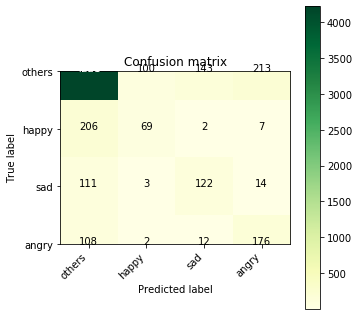

array([[4221,  100,  143,  213],
       [ 206,   69,    2,    7],
       [ 111,    3,  122,   14],
       [ 108,    2,   12,  176]])

In [91]:
support_vector_machine_one_vs_rest = svm.SVC(decision_function_shape = 'ovr', kernel = 'linear', C = 100)
support_vector_machine_one_vs_rest.fit(emoji_all, label)
support_vector_machine_one_vs_rest_predictions = support_vector_machine_one_vs_rest.predict(emoji_test)
print_metrics(support_vector_machine_one_vs_rest_predictions)
plot_confusion_matrix(metrics.confusion_matrix(test_label, support_vector_machine_one_vs_rest_predictions), tokens)
plt.show()
metrics.confusion_matrix(test_label, support_vector_machine_one_vs_rest_predictions)